## <p style="background-color:skyblue; font-family:newtimeroman; font-size:180%; text-align:center">1. Introduction</p>

Wikipedia Says - In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. 

In simple terms - In ensembling we try to use the learnings from multiple algorithms to make a more efficient algorithm. For example Random Forest algorithms - It's a ensembling algorithm that uses multiple decision trees. Look at the below picture - 

<img src="https://www.kdnuggets.com/wp-content/uploads/ensemble-framework-packt.jpg">



<br/>So we try to use multiple algorithms to enhance the performance. The concept of ensembling is pretty simple. What's required is a robust technique to do this ensembling. In this Notebook we'll se what are techniques used for ensembling. For ex - 

- Weighted Ensembling Approach
- VotingClassifier
- StackingClassifier
- Ensembling using a custom model
- Bayesian optimal classifier.

Details in each forthcoming sections. We'll cover each step of model development. 

- Data Processing
- Feature Engineering
- Model Development
- Ensembling
- Evaluation

Let's Begin!

In [1]:
# Basic Library
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

# sklearn utility
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics   
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedStratifiedKFold

## XGBoost
from xgboost import XGBClassifier
import xgboost as xgb

### LightGBM
from lightgbm import LGBMClassifier
import lightgbm as lgb

### CatBoost
from catboost import CatBoostClassifier
import catboost as catboost

## sklearn ensembles 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Reading the Data!

In [2]:
# Titanic Dataset
titanic_train = pd.read_csv("../input/titanic/train.csv")
titanic_test = pd.read_csv("../input/titanic/test.csv")
dataset = "titanic"
IdCol = 'PassengerId'
targetCol = 'Survived'
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## <p style="background-color:skyblue; font-family:newtimeroman; font-size:180%; text-align:center">2. Data Preparation</p>

In [3]:
titanic_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
titanic_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
titanic_train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [6]:
int_or_float = titanic_train.dtypes[titanic_train.dtypes.isin(['int64', 'float64'])].index
print("Int or Flaot Columns : ", list(int_or_float))
num_cols = ['Age', 'SibSp', 'Parch', "Fare"]
print("Num Cols : ", num_cols)
cat_cols = ['Pclass', 'Sex', 'Embarked']
print("Cat Cols : ", cat_cols)

Int or Flaot Columns :  ['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch']
Num Cols :  ['Age', 'SibSp', 'Parch', 'Fare']
Cat Cols :  ['Pclass', 'Sex', 'Embarked']


In [7]:
train_len = len(titanic_train)
combined =  pd.concat(objs=[titanic_train, titanic_test], axis=0).reset_index(drop=True)
#combined.tail()

### 2.1) Missing Values

In [8]:
def missing_values_details(df):
    total = df.isnull().sum()
    
    missing_df = pd.DataFrame({'count_missing': total}).reset_index().rename(columns={'index':'column_name'})
    missing_df['percent_missing'] = missing_df['count_missing']/len(df)
    missing_df = missing_df.sort_values(by='count_missing', ascending=False)
    missing_df = missing_df[missing_df['count_missing']!=0]
    print('Info : {} out of {} columns have mising values'.format(len(missing_df), len(df.columns)))
    missing_90 = missing_df[missing_df['percent_missing']>0.9]
    missing_80 = missing_df[missing_df['percent_missing']>0.8]
    missing_70 = missing_df[missing_df['percent_missing']>0.7]
    print("Info : {} columns have more that 90% missing values".format(len(missing_90)))
    print("Info : {} columns have more that 80% missing values".format(len(missing_80)))
    print("Info : {} columns have more that 70% missing values".format(len(missing_70)))
    
    return missing_df

In [9]:
missing_values_details(titanic_train)

Info : 3 out of 12 columns have mising values
Info : 0 columns have more that 90% missing values
Info : 0 columns have more that 80% missing values
Info : 1 columns have more that 70% missing values


,column_name,count_missing,percent_missing
10,Cabin,687,0.771044
5,Age,177,0.198653
11,Embarked,2,0.002245


### 2.2) Check for class balance

In [10]:
def check_class_balance(df, target_col):
    counts = df[target_col].value_counts()
    class_df = pd.DataFrame(counts).reset_index().rename(columns={target_col:'counts', 'index':'class'})
    class_df.plot.bar(x='class', y='counts')
    print('Info : There are {} classes in the target column'.format(len(class_df)))
    max_class = class_df['counts'].max() 
    min_class = class_df['counts'].min()
    max_diff = max_class - min_class
    print("Info : Maximum difference between 2 classes is {} observations that is {} times w.r.t. minimum class".format(max_diff, (max_diff/min_class)))
    return class_df

Info : There are 2 classes in the target column
Info : Maximum difference between 2 classes is 207 observations that is 0.6052631578947368 times w.r.t. minimum class


,class,counts
0,0,549
1,1,342


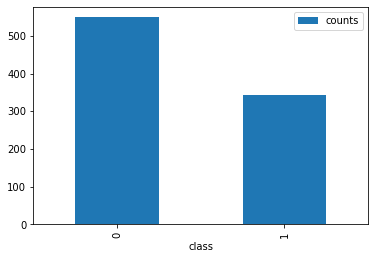

In [11]:
check_class_balance(titanic_train, 'Survived')

### 2.3) Outliers

In [12]:
def detect_outliers(df,n,features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from num_cols
outliers_rows = detect_outliers(titanic_train,2,num_cols)
print(len(outliers_rows))
# Drop outliers
titanic_train = titanic_train.drop(outliers_rows, axis = 0).reset_index(drop=True)

10


## <p style="background-color:skyblue; font-family:newtimeroman; font-size:180%; text-align:center">3. Feature Engineering</p>

### 3.1) Numerical columns

In [13]:
def describe_num_col(train, col):
    #### This function provides detailed comparison of a numerical varible
    ### missing value
    count_train = train[col].isnull().sum()
    #print("######    Variable Name : {}    ######".format(col))
    
    #### Skewness and Kurtosis
    train_k = stats.kurtosis(train[col].dropna(), bias=False)
    
    train_s = stats.skew(train[col].dropna(), bias=False)
    
    #### Outliers
    
    def count_outliers(df, col):
        mean_d = np.mean(df[col])
        std_d = np.std(df[col])
        
        scaled = (df[col]-mean_d)/std_d
        outliers = abs(scaled) > 3
        if len(outliers.value_counts()) > 1:
            return outliers.value_counts()[1]
        else:
            return 0   
    
    train_o = count_outliers(train, col)
        
    summ_df = pd.DataFrame({'info':['missing_count', 'missing_percent', 'skewness', 'kurtosis', 'outlier_count', 'outlier_percent'],
                           'train_set':[count_train, (count_train/len(train))*100, train_s, train_k, train_o, (train_o/len(train))*100]})
    
#     print("######    Summary Data")
#     display(summ_df)
    
    #print("######    Distribution and Outliers comparision plots")
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
    plot10 = sns.distplot(train[train['Survived']==0][col],ax=ax1, label='Not Survived')
    sns.distplot(train[train['Survived']==1][col],ax=ax1,color='red', label='Survived')
    plot10.axes.legend()
    ax1.set_title('Distribution of {name}'.format(name=col))
    
    sns.boxplot(x='Survived',y=col,data=train,ax=ax2)
    #plt.xticks(ticks=[0,1],labels=['Non-Diabetes','Diabetes'])
    ax2.set_xlabel('Category') 
    ax2.set_title('Boxplot of {name}'.format(name=col))
    
    
    fig.show()    
    
    return

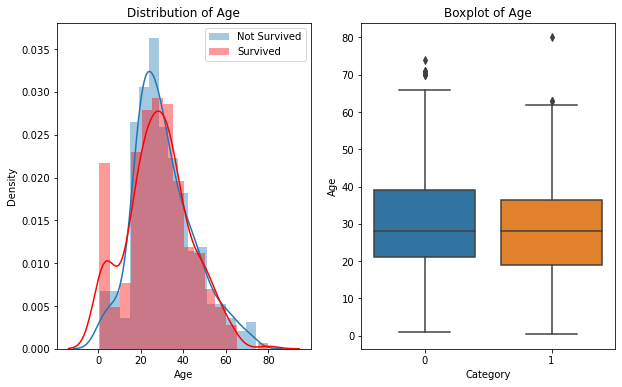

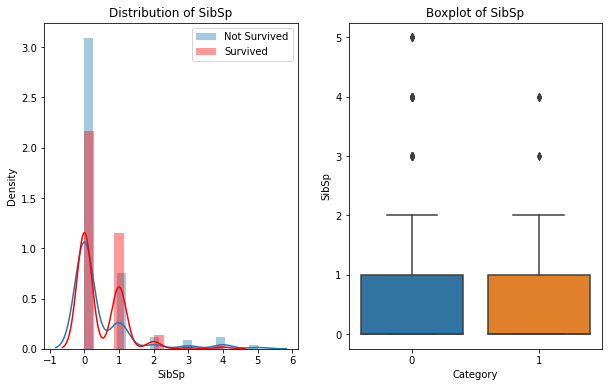

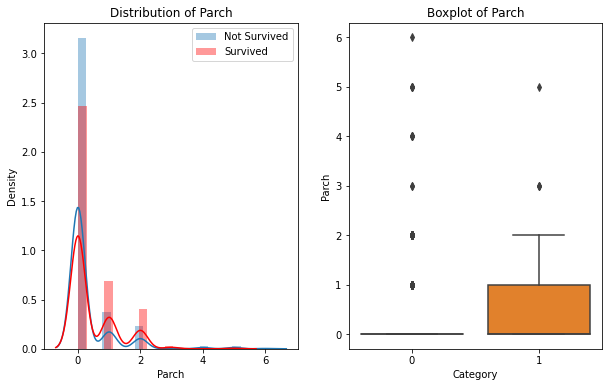

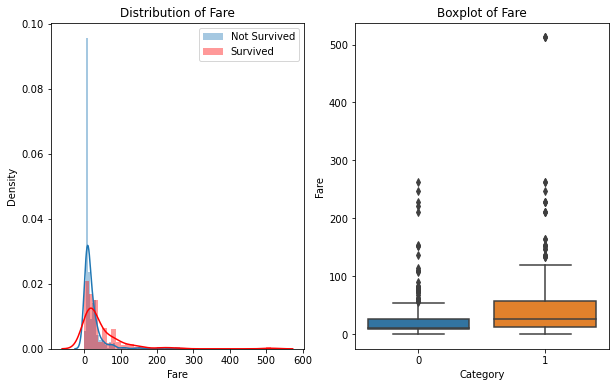

In [14]:
for col in num_cols:
    describe_num_col(titanic_train, col)

In [15]:
### The column Fare is continuous and it is right skewed
# Apply log transformation to Fare to reduce skewness distribution
combined["Fare"] = combined["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

### 3.2) Catrgorical columns

In [16]:
def describe_cat_col(df, col):
    ### unique values
    count_u = df[col].nunique()
    #print("Info : There are {} unique values".format(count_u))
    nulls = df[col].isnull().sum()
    #print("Info : There are {} missing values that is {} percent".format(nulls, nulls/len(df)))
    
    ### Percent share df
    share_df = pd.DataFrame(df[col].value_counts()).reset_index().rename(columns={'index':'class_name',col:'counts'})
    share_df['percent_share'] = share_df['counts']/sum(share_df['counts'])
    share_df = share_df.sort_values(by='percent_share', ascending=False)
    #display(share_df)
        
        
    if (count_u > 3 and count_u < 10):
        fig, ax  = plt.subplots()
        fig.suptitle(col + ' Distribution', color = 'red')
        explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])
        labels = list(df[col].dropna().unique())
        sizes = df[col].value_counts()
        #ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
        ax.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
        ax.add_artist(plt.Circle((0,0),0.2,fc='white'))
        plt.show()
    
    else:
        plt.figure()
        plt.title(col + ' Distribution', color = 'red')
        sns.barplot(x=col,y='Survived', data = df)
        plt.show()
        
    return

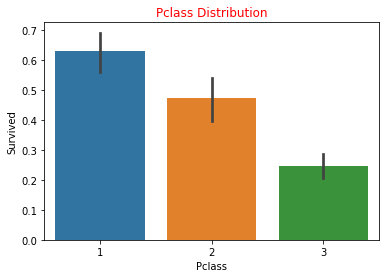

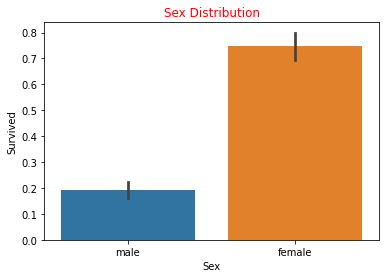

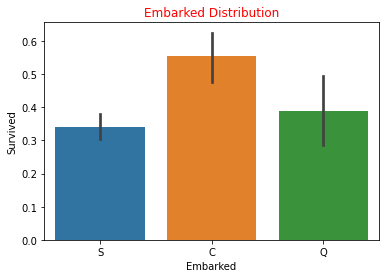

In [17]:
for col in cat_cols:
    #print("Column Name : {}".format(col))
    describe_cat_col(titanic_train, col)

### 3.3) Filling the missing values
3.3.1 - Embarked

In [18]:
#### Filling the Embarked column with mode
combined['Embarked'] = combined['Embarked'].fillna(combined['Embarked'].value_counts().index[0])
combined['Embarked'].isnull().sum()

0

In [19]:
combined = pd.get_dummies(combined, columns = ["Embarked"], prefix="Em")

3.3.2 Age

[Reference](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)

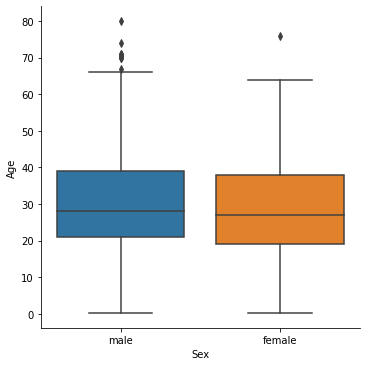

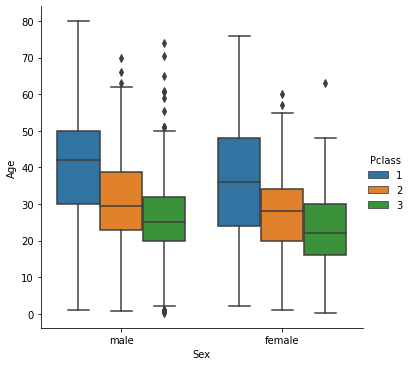

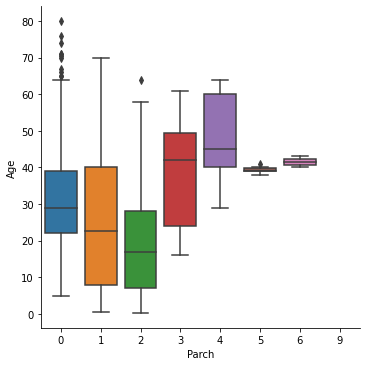

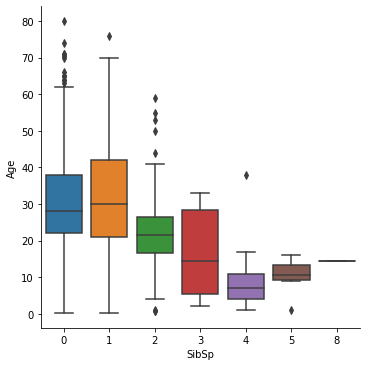

In [20]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=combined,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=combined,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=combined,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=combined,kind="box")

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1st class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [21]:
# convert Sex into categorical value 0 for male and 1 for female
combined["Sex"] = combined["Sex"].map({"male": 0, "female":1})

# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(combined["Age"][combined["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = combined["Age"].median()
    age_pred = combined["Age"][((combined['SibSp'] == combined.iloc[i]["SibSp"]) & (combined['Parch'] == combined.iloc[i]["Parch"]) & (combined['Pclass'] == combined.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        combined['Age'].iloc[i] = age_pred
    else :
        combined['Age'].iloc[i] = age_med

3.3.3 Cabin

In [22]:
combined['Cabin'].describe()

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object

In [23]:
# Replace the Cabin number by the type of cabin 'X' if not
combined["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in combined['Cabin'] ])

In [24]:
combined = pd.get_dummies(combined, columns = ["Cabin"],prefix="Cabin")

### 3.4) Feature Transformation

3.4.1 Name -> Title

In [25]:
# Get Title from Name
combined_title = [i.split(",")[1].split(".")[0].strip() for i in combined["Name"]]
combined["Title"] = pd.Series(combined_title)
combined["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [26]:
# Convert to categorical values Title 
combined["Title"] = combined["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
combined["Title"] = combined["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
combined["Title"] = combined["Title"].astype(int)

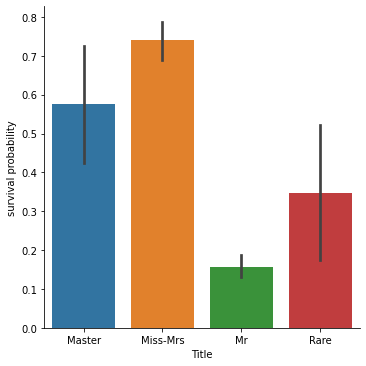

In [27]:
g = sns.factorplot(x="Title",y="Survived",data=combined,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [28]:
# Drop Name variable
combined.drop(labels = ["Name"], axis = 1, inplace = True)

3.4.2 Ticket

In [29]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(combined.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
combined["Ticket"] = Ticket
combined["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [30]:
combined = pd.get_dummies(combined, columns = ["Ticket"], prefix="T")

3.4.2 Pclass

In [31]:
# Create categorical values for Pclass
combined["Pclass"] = combined["Pclass"].astype("category")
combined = pd.get_dummies(combined, columns = ["Pclass"],prefix="Pc")

In [32]:
# Drop useless variables 
combined.drop(labels = ["PassengerId"], axis = 1, inplace = True)

### This sums-up the feature engineering part. We have the development data ready now.

In [33]:
combined.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S,Cabin_A,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [34]:
train = combined[:train_len]
test = combined[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)
train["Survived"] = train["Survived"].astype(int)
y = train["Survived"]
train = train.drop(labels = ["Survived"],axis = 1)
train_x, val_x, train_y, val_y = train_test_split(train, y, test_size=0.2)
test_id = titanic_test['PassengerId']
test_x = test

In [35]:
assert len(train_x.columns) == len(test_x.columns)

### Some utility functions

In [36]:
### Function to evaluate model performance

def evaluate_model_performnce(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualizing model performance
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 

    tn, fp, fn, tp = cm.ravel()
    #print(tn, fp, fn, tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = ((tp+tn)/(tp+tn+fp+fn))*100
    print("Precision : ",precision)
    print("Recall : ",recall)
    print("F1 Score : ",f1)
    print("Validation Accuracy : ",accuracy)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy Score : ", accuracy)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    print("AUC Value : ", auc)
    
    return accuracy, auc, f1

In [37]:
## Function to create the submission file

def make_submission_file(filename, probab, test_id, IdCol, targetCol, threshold=None):
    submit = pd.DataFrame()
    submit[IdCol] = test_id
    submit[targetCol] = probab
    if threshold!=None:
        pred = [1 if x>=threshold else 0 for x in probab]
        submit[targetCol] = pred
    submit.to_csv(filename, index=False)
    return submit

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:180%; text-align:center">Model Development</p>

> ### Training the base learners

### Before directly jumping into ensembling. Let's first train some models individually and see how they are performing. 
We'll train the best models -
- XGBoost
- LightBoost
- CatBoost 
<br/>

And the ensemble them. Later we can check with other models too.

Note - We'll be using default parameter's as of now.

## 1) XGBoost

In [38]:
xgb_clf = XGBClassifier()
xgb_clf.fit(train_x, train_y,eval_metric=["auc", "logloss"],verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Precision :  0.8051948051948052
Recall :  0.8157894736842105
F1 Score :  0.8104575163398693
Validation Accuracy :  83.79888268156425
Accuracy Score :  0.8379888268156425
AUC Value :  0.8350792028615228


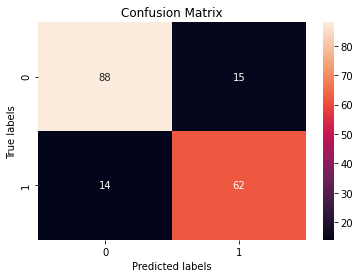

In [39]:
threshold = 0.4
xgb_val_prob = xgb_clf.predict_proba(val_x)
xgb_val_prob = pd.DataFrame(xgb_val_prob)[1]
xgb_val_pred = [1 if x >= threshold else 0 for x in xgb_val_prob]
xgb_acc, xgb_auc, xgb_f1 = evaluate_model_performnce(val_y, xgb_val_pred) 

Making prediction of leaderboard dataset

In [40]:
xgb_prob = xgb_clf.predict_proba(test_x)
xgb_prob = pd.DataFrame(xgb_prob)[1]

In [41]:
#xgb_prob

Writitng the submission file

In [42]:
xgb_sub = make_submission_file(dataset+"_xgb_default.csv", xgb_prob, test_id, IdCol, targetCol, threshold=0.5)
xgb_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


## 2) LightGBM

In [43]:
lgb_clf = LGBMClassifier()
lgb_clf.fit(train_x, train_y)

LGBMClassifier()

Precision :  0.8289473684210527
Recall :  0.8289473684210527
F1 Score :  0.8289473684210527
Validation Accuracy :  85.47486033519553
Accuracy Score :  0.8547486033519553
AUC Value :  0.8513668880940216


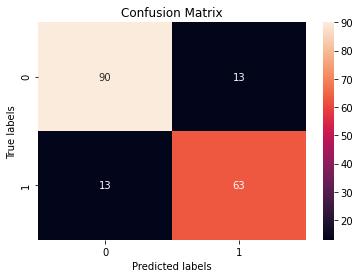

In [44]:
threshold = 0.4
lgb_val_prob = lgb_clf.predict_proba(val_x)
lgb_val_prob = pd.DataFrame(lgb_val_prob)[1]
lgb_val_pred = [1 if x >= threshold else 0 for x in lgb_val_prob]
lgb_acc, lgb_auc, lgb_f1 = evaluate_model_performnce(val_y, lgb_val_pred) 

Making prediction of leaderboard dataset

In [45]:
lgb_prob = lgb_clf.predict_proba(test_x)
lgb_prob = pd.DataFrame(lgb_prob)[1]

In [46]:
#lgb_prob

Writitng the submission file

In [47]:
lgb_sub = make_submission_file(dataset+"_lgb_default.csv", lgb_prob, test_id, IdCol, targetCol, threshold=0.5)
lgb_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


### 3) CatBoost

In [48]:
cat_clf = CatBoostClassifier(verbose=0)
cat_clf.fit(train_x, train_y)

Precision :  0.8289473684210527
Recall :  0.8289473684210527
F1 Score :  0.8289473684210527
Validation Accuracy :  85.47486033519553
Accuracy Score :  0.8547486033519553
AUC Value :  0.8513668880940216


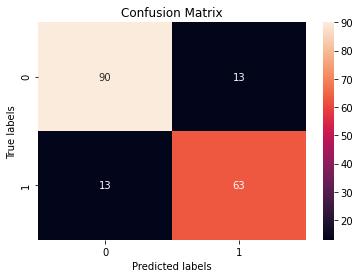

In [49]:
threshold = 0.4
cat_val_prob = cat_clf.predict_proba(val_x)
cat_val_prob = pd.DataFrame(cat_val_prob)[1]
cat_val_pred = [1 if x >= threshold else 0 for x in cat_val_prob]
cat_acc, cat_auc, cat_f1 = evaluate_model_performnce(val_y, cat_val_pred) 

Making prediction of leaderboard dataset

In [50]:
cat_prob = cat_clf.predict_proba(test_x)
cat_prob = pd.DataFrame(cat_prob)[1]

In [51]:
#cat_prob

Writitng the submission file

In [52]:
cat_sub = make_submission_file(dataset+"_cat_default.csv", cat_prob, test_id, IdCol, targetCol, threshold=0.5)
cat_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


## <p style="background-color:skyblue; font-family:newtimeroman; font-size:180%; text-align:center">Ensembling</p>

## Finally Ensembling!

> #### If you are absolute beginner to ensembling and find this notebook a bit difficult to follow. I encourage you to lokk at this thread [Gateway to Ensembling!!](https://www.kaggle.com/getting-started/219696)

Now we'll se how we can combine the learning from individual models and make an ensemble.

### 1) Weighted Ensembling Approach

This is the most simple approach for ensembling. We take weighted average of the scores of individual model that gives us the ensembled score. You can decide the weight of an individual model based on the validation score of that model or your experience. 

Note - We can treat these weights as hyperparameter and optimize them like we do in Logistic Regression. (w1x1 + w2x2 + ....) Right? Yes, This is the next technique.

Ensembling on Validation Set and evaluating it!

In [53]:
ens_val_prob = 0.4*cat_val_prob + 0.3*lgb_val_prob + 0.3*xgb_val_prob

Precision :  0.8533333333333334
Recall :  0.8421052631578947
F1 Score :  0.847682119205298
Validation Accuracy :  87.15083798882681
Accuracy Score :  0.8715083798882681
AUC Value :  0.8676545733265203


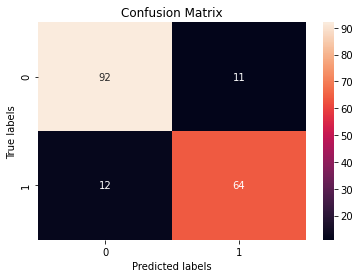

In [54]:
threshold = 0.4
ens_val_pred = [1 if x >= threshold else 0 for x in ens_val_prob]
ens_acc, ens_auc, ens_f1 = evaluate_model_performnce(val_y, ens_val_pred) 

On Leaderboard set

In [55]:
ens_prob = 0.4*cat_prob + 0.3*lgb_prob + 0.3*xgb_prob

In [56]:
#y_prob

In [57]:
ens_sub = make_submission_file(dataset+"_weighted_ens.csv", ens_prob, test_id, IdCol, targetCol, threshold=0.5)
ens_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


## 2) Ensemblinng using a ML model

Like discussed in the previous section here we train a separate model on the outcome of individual models and then using that model an ensembled model.

In [58]:
trained_clfs = [xgb_clf, lgb_clf, cat_clf]

def ensembling_engine(trained_clfs, train_x, train_y, test_x, ensembler):
    train_matrix = np.empty((train_x.shape[0], len(trained_clfs)))
    for (n, clf) in enumerate(trained_clfs):
        train_matrix[:,n] = pd.DataFrame(clf.predict_proba(train_x))[1]      #pd.DataFrame(cat_prob)[1]
        
    ensembler.fit(train_matrix, train_y)
    
    test_matrix = np.empty((test_x.shape[0], len(trained_clfs)))
    for (n, clf) in enumerate(trained_clfs):
        test_matrix[:,n] = pd.DataFrame(clf.predict_proba(test_x))[1]   
        
    ens_prob = ensembler.predict_proba(test_matrix)
    return ens_prob

### 2.1) Logistic Regression

Let's try with simple logistic regression. We'll do ensembling on Validation Set and then evaluate it!

In [59]:
ensembler = LogisticRegression()

Precision :  0.8493150684931506
Recall :  0.8157894736842105
F1 Score :  0.832214765100671
Validation Accuracy :  86.03351955307262
Accuracy Score :  0.8603351955307262
AUC Value :  0.8544966785896781


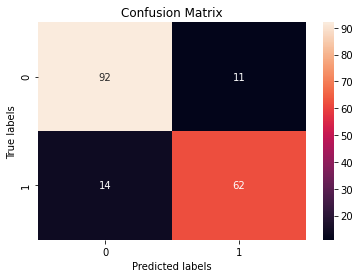

In [60]:
lr_ens_val_prob = ensembling_engine(trained_clfs, train_x, train_y, val_x, ensembler)
lr_ens_val_prob = pd.DataFrame(lr_ens_val_prob)[1]
threshold = 0.4
lr_ens_val_pred = [1 if x >= threshold else 0 for x in lr_ens_val_prob]
le_ens_acc, lr_ens_auc, lr_ens_f1 = evaluate_model_performnce(val_y, lr_ens_val_pred) 

Ensembling on leaderboard dataset

In [61]:
lr_ens_prob = ensembling_engine(trained_clfs, train_x, train_y, test_x, ensembler)
lr_ens_prob = pd.DataFrame(lr_ens_prob)[1]
#lr_ens_prob
lr_ens_sub = make_submission_file(dataset+"lr_ens.csv", lr_ens_prob, test_id, IdCol, targetCol, threshold=0.5)
lr_ens_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


### 2.2) RandomForest

Let's try with random forest. We'll do ensembling on Validation Set and then evaluate it!

In [62]:
ensembler = RandomForestClassifier()

Precision :  0.775
Recall :  0.8157894736842105
F1 Score :  0.7948717948717949
Validation Accuracy :  82.12290502793296
Accuracy Score :  0.8212290502793296
AUC Value :  0.8205160960654062


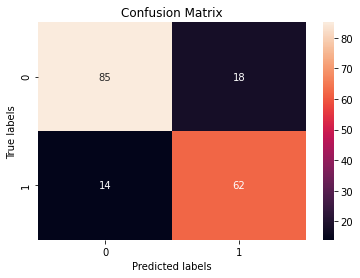

In [63]:
rfc_ens_val_prob = ensembling_engine(trained_clfs, train_x, train_y, val_x, ensembler)
rfc_ens_val_prob = pd.DataFrame(rfc_ens_val_prob)[1]
threshold = 0.4
rfc_ens_val_pred = [1 if x >= threshold else 0 for x in rfc_ens_val_prob]
rfc_ens_acc, rfc_ens_auc, rfc_ens_f1 = evaluate_model_performnce(val_y, rfc_ens_val_pred) 

In [64]:
rfc_ens_prob = ensembling_engine(trained_clfs, train_x, train_y, test_x, ensembler)
rfc_ens_prob = pd.DataFrame(rfc_ens_prob)[1]
#rfc_ens_prob
rfc_ens_sub = make_submission_file(dataset+"rfc_ens.csv", rfc_ens_prob, test_id, IdCol, targetCol, threshold=0.5)
rfc_ens_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


### 2.3) Gradient Booster

Let's try with gradient booster. We'll do ensembling on Validation Set and then evaluate it!

In [65]:
ensembler = GradientBoostingClassifier()

Precision :  0.7848101265822784
Recall :  0.8157894736842105
F1 Score :  0.7999999999999999
Validation Accuracy :  82.68156424581005
Accuracy Score :  0.8268156424581006
AUC Value :  0.8253704649974452


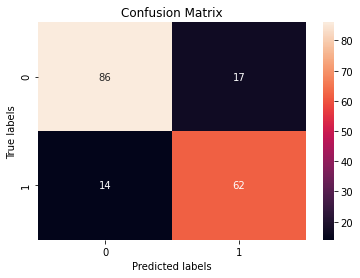

In [66]:
gbc_ens_val_prob = ensembling_engine(trained_clfs, train_x, train_y, val_x, ensembler)
gbc_ens_val_prob = pd.DataFrame(gbc_ens_val_prob)[1]
threshold = 0.4
gbc_ens_val_pred = [1 if x >= threshold else 0 for x in gbc_ens_val_prob]
gbc_ens_acc, gbc_ens_auc, gbc_ens_f1 = evaluate_model_performnce(val_y, gbc_ens_val_pred) 

In [67]:
gbc_ens_prob = ensembling_engine(trained_clfs, train_x, train_y, test_x, ensembler)
gbc_ens_prob = pd.DataFrame(gbc_ens_prob)[1]
#gbc_ens_prob
gbc_ens_sub = make_submission_file("gbc_ens.csv", gbc_ens_prob, test_id, IdCol, targetCol, threshold=0.5)
gbc_ens_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,1


The next two methods are used on untrained-classifier.

### 3) VotingClassifier

It's a hard/soft Voting/Majority Rule classifier for unfitted estimators. In ‘hard’ mode, it uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers. It's available in sklearn.

In [68]:
from sklearn.ensemble import VotingClassifier

In [69]:
v_xgb = XGBClassifier()
v_lgb = LGBMClassifier()
v_cat = CatBoostClassifier(verbose=0)

v_clf = VotingClassifier(estimators=[('xgb', v_xgb), ('lgb', v_lgb), ('cat', v_cat)], voting='soft')
v_clf.fit(train_x, train_y)

[13:06:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
 

Precision :  0.8533333333333334
Recall :  0.8421052631578947
F1 Score :  0.847682119205298
Validation Accuracy :  87.15083798882681
Accuracy Score :  0.8715083798882681
AUC Value :  0.8676545733265203


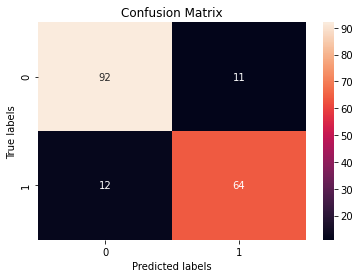

In [70]:
threshold = 0.4
v_val_prob = v_clf.predict_proba(val_x)
v_val_prob = pd.DataFrame(v_val_prob)[1]
v_val_pred = [1 if x >= threshold else 0 for x in v_val_prob]
v_acc, v_auc, v_f1 = evaluate_model_performnce(val_y, v_val_pred) 

Making prediction on leaderboard dataset

In [71]:
v_prob = v_clf.predict_proba(test_x)
v_prob = pd.DataFrame(v_prob)[1]

Writing submission file

In [72]:
v_sub = make_submission_file(dataset+"_voting_ens.csv", v_prob, test_id, IdCol, targetCol, threshold=0.5)
v_sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


### 4) StackingClassifier

Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator. So basically what we have implemented in technique 2 is similar to stacking classifier. It's readily available in sklearn.

In [73]:
from sklearn.ensemble import StackingClassifier

In [74]:
st_xgb = XGBClassifier()
st_lgb = LGBMClassifier()
st_cat = CatBoostClassifier(verbose=0)

st_clf = StackingClassifier(estimators=[('xgb', st_xgb), ('lgb', st_lgb), ('cat', st_cat)], 
                            final_estimator=GradientBoostingClassifier())
st_clf.fit(train_x, train_y)

[13:06:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:06:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:06:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:06:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None,
                                              max_depth=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100,

Precision :  0.7948717948717948
Recall :  0.8157894736842105
F1 Score :  0.8051948051948051
Validation Accuracy :  83.24022346368714
Accuracy Score :  0.8324022346368715
AUC Value :  0.830224833929484


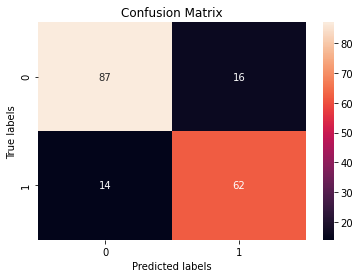

In [75]:
threshold = 0.4
st_val_prob = st_clf.predict_proba(val_x)
st_val_prob = pd.DataFrame(st_val_prob)[1]
st_val_pred = [1 if x >= threshold else 0 for x in st_val_prob]
st_acc, st_auc, st_f1 = evaluate_model_performnce(val_y, st_val_pred) 

Making Prediction on leaderboard dataset

In [76]:
st_prob = st_clf.predict_proba(test_x)
st_prob = pd.DataFrame(st_prob)[1]

Writing submission file

In [77]:
st_sub = make_submission_file(dataset+"_stacking_ens.csv", st_prob, test_id, IdCol, targetCol, threshold=0.5)
st_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


#### These are some of the methods used for ensembling. If you found this kernel interesting consider UPVOTING it. Thanks! #Open_to_discussion.

#### I have prepared another notebook on Hyper-parameter optimization that you may find insightful. Here - [Getting Started with Hyper-parameter Optimization](https://www.kaggle.com/pashupatigupta/getting-started-with-hyper-parameter-optimization). One highlight is that it talks about Bayesian Optimization in detail.

### Happy Learning!!